In [1]:
!git clone https://github.com/januar-png/earlystop.git

Cloning into 'earlystop'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 77 (delta 39), reused 17 (delta 7), pack-reused 0
Receiving objects: 100% (77/77), 10.91 MiB | 14.26 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [2]:
pip install jcopdl==1.1.1

  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-1.1.1-py2.py3-none-any.whl size=12589 sha256=73d79bb296325b97a0ffc72d4ec8807c170ee55135d84de81005a08e14a94500
  Stored in directory: /root/.cache/pip/wheels/6d/46/c4/fbd4a6c344375a840af6eb98af862a0b12da406d4fbc2aa882
Successfully built jcopdl
Note: you may need to restart the kernel to use updated packages.


In [3]:
from jcopdl.layers import linear_block 
from jcopdl.callback import Callback

In [4]:
from earlystop import Earlystop

In [5]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [42]:
batch_size = 32
img_size = 224, 224

train_transform = transforms.Compose([
    transforms.RandomRotation(7),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(size=(img_size)),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('/kaggle/input/padi-data/train', transform = train_transform)
trainloader = DataLoader(train_set, batch_size, shuffle = True)

val_set = datasets.ImageFolder('/kaggle/input/padi-data/val', transform = val_transform)
valloader = DataLoader(val_set, batch_size, shuffle = False)

In [43]:
feature, label = next(iter(valloader))
print(feature.shape)

torch.Size([32, 3, 224, 224])


In [44]:
def ConvBlock(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

In [45]:
class CNNpenyakitPadi(nn.Module):
    def __init__(self, output_size):
        super(CNNpenyakitPadi, self).__init__()
        self.feature = nn.Sequential(
            
            ConvBlock(3, 16),
            nn.MaxPool2d(2,2),
            
            ConvBlock(16, 32),
            nn.MaxPool2d(2,2),
            
            ConvBlock(32, 64),
            nn.MaxPool2d(2,2),
                         
            ConvBlock(64, 128),
            nn.MaxPool2d(2,2),
            
            ConvBlock(128, 256),
            nn.MaxPool2d(2,2),
            
            ConvBlock(256, 512),
            nn.MaxPool2d(2,2),
            
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            linear_block(512*3*3, 256, activation='relu'),
            linear_block(256, output_size, activation='softmax')
        )
    def forward(self, x):
        x = self.feature(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [46]:
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [47]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [48]:
def fit(train_set, trainloader, val_set, valloader, model, criterion, optimizer, device, scheduler, early_stop, epochs):
    for epoch in range(epochs):
        train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
        with torch.no_grad():
            test_cost, test_score = loop_fn("test", val_set, valloader, model, criterion, optimizer, device)
        
        scheduler.step(test_cost)
        early_stop.log(train_cost, test_cost, train_score, test_score)

        if early_stop.early_stopping(model, monitor="test_cost") or epoch >= epochs - 1:
            early_stop.plot_cost()
            early_stop.plot_score()
            break

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNpenyakitPadi(output_size = len(train_set.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-6)
scheduler = ReduceLROnPlateau(optimizer, 'min',patience=1)
callback = Earlystop(model, outdir="model", early_stop_patience=2)
epoch = 50

In [50]:
1.0016-0.9945

0.007099999999999995

Test: 100%|██████████| 12/12 [00:17<00:00,  1.44s/it]


Epoch 1: train_loss=1.3816, val_loss=1.3834, train_score=0.2595, val_score=0.3278


Test: 100%|██████████| 12/12 [00:17<00:00,  1.46s/it]


Epoch 2: train_loss=1.3558, val_loss=1.3466, train_score=0.4960, val_score=0.4917


Test: 100%|██████████| 12/12 [00:17<00:00,  1.42s/it]


Epoch 3: train_loss=1.3260, val_loss=1.3154, train_score=0.6341, val_score=0.6222


Test: 100%|██████████| 12/12 [00:17<00:00,  1.43s/it]


Epoch 4: train_loss=1.2898, val_loss=1.2826, train_score=0.6635, val_score=0.6250


Test: 100%|██████████| 12/12 [00:17<00:00,  1.42s/it]


Epoch 5: train_loss=1.2466, val_loss=1.2444, train_score=0.6857, val_score=0.6472


Test: 100%|██████████| 12/12 [00:17<00:00,  1.45s/it]


Epoch 6: train_loss=1.2017, val_loss=1.2065, train_score=0.6968, val_score=0.6611


Test: 100%|██████████| 12/12 [00:16<00:00,  1.40s/it]


Epoch 7: train_loss=1.1628, val_loss=1.1722, train_score=0.7048, val_score=0.6778


Test: 100%|██████████| 12/12 [00:16<00:00,  1.38s/it]


Epoch 8: train_loss=1.1234, val_loss=1.1407, train_score=0.7151, val_score=0.7000


Test: 100%|██████████| 12/12 [00:16<00:00,  1.34s/it]


Epoch 9: train_loss=1.0958, val_loss=1.1085, train_score=0.7286, val_score=0.7111


Test: 100%|██████████| 12/12 [00:16<00:00,  1.38s/it]


Epoch 10: train_loss=1.0680, val_loss=1.0865, train_score=0.7349, val_score=0.7306


Test: 100%|██████████| 12/12 [00:16<00:00,  1.38s/it]


Epoch 11: train_loss=1.0541, val_loss=1.0583, train_score=0.7548, val_score=0.7806


Test: 100%|██████████| 12/12 [00:16<00:00,  1.38s/it]


Epoch 12: train_loss=1.0308, val_loss=1.0359, train_score=0.7825, val_score=0.7972


Test: 100%|██████████| 12/12 [00:16<00:00,  1.38s/it]


Epoch 13: train_loss=1.0139, val_loss=1.0241, train_score=0.7937, val_score=0.8056


Test: 100%|██████████| 12/12 [00:16<00:00,  1.39s/it]


Epoch 14: train_loss=1.0009, val_loss=1.0049, train_score=0.8206, val_score=0.8444


Test: 100%|██████████| 12/12 [00:16<00:00,  1.36s/it]


Epoch 15: train_loss=0.9856, val_loss=0.9895, train_score=0.8238, val_score=0.8556


Test: 100%|██████████| 12/12 [00:16<00:00,  1.40s/it]


Epoch 16: train_loss=0.9763, val_loss=0.9790, train_score=0.8421, val_score=0.8611


Test: 100%|██████████| 12/12 [00:16<00:00,  1.37s/it]


Epoch 17: train_loss=0.9630, val_loss=0.9649, train_score=0.8476, val_score=0.8611


Test: 100%|██████████| 12/12 [00:16<00:00,  1.37s/it]


Epoch 18: train_loss=0.9519, val_loss=0.9551, train_score=0.8524, val_score=0.8667


Test: 100%|██████████| 12/12 [00:16<00:00,  1.38s/it]


Epoch 19: train_loss=0.9542, val_loss=0.9530, train_score=0.8413, val_score=0.8639


Test: 100%|██████████| 12/12 [00:16<00:00,  1.38s/it]


Epoch 20: train_loss=0.9466, val_loss=0.9423, train_score=0.8516, val_score=0.8639


Test: 100%|██████████| 12/12 [00:16<00:00,  1.35s/it]


Epoch 21: train_loss=0.9339, val_loss=0.9328, train_score=0.8611, val_score=0.8667


Test: 100%|██████████| 12/12 [00:16<00:00,  1.36s/it]


Epoch 22: train_loss=0.9282, val_loss=0.9338, train_score=0.8651, val_score=0.8667
EarlyStop patience =  1. Best test_cost: 0.9328


Test: 100%|██████████| 12/12 [00:16<00:00,  1.37s/it]


Epoch 23: train_loss=0.9250, val_loss=0.9211, train_score=0.8698, val_score=0.8778


Test: 100%|██████████| 12/12 [00:16<00:00,  1.37s/it]


Epoch 24: train_loss=0.9209, val_loss=0.9103, train_score=0.8730, val_score=0.8806


Test: 100%|██████████| 12/12 [00:16<00:00,  1.36s/it]


Epoch 25: train_loss=0.9167, val_loss=0.9063, train_score=0.8754, val_score=0.8833


Test: 100%|██████████| 12/12 [00:16<00:00,  1.39s/it]


Epoch 26: train_loss=0.9147, val_loss=0.8976, train_score=0.8794, val_score=0.8917


Test: 100%|██████████| 12/12 [00:16<00:00,  1.39s/it]


Epoch 27: train_loss=0.9125, val_loss=0.9052, train_score=0.8659, val_score=0.8750
EarlyStop patience =  1. Best test_cost: 0.8976


Test: 100%|██████████| 12/12 [00:16<00:00,  1.40s/it]


Epoch 28: train_loss=0.9088, val_loss=0.8953, train_score=0.8794, val_score=0.8889


Test: 100%|██████████| 12/12 [00:16<00:00,  1.40s/it]


Epoch 29: train_loss=0.9074, val_loss=0.8932, train_score=0.8706, val_score=0.8889


Test: 100%|██████████| 12/12 [00:16<00:00,  1.40s/it]


Epoch 30: train_loss=0.8950, val_loss=0.8936, train_score=0.8865, val_score=0.8750
EarlyStop patience =  1. Best test_cost: 0.8932


Test: 100%|██████████| 12/12 [00:16<00:00,  1.40s/it]


Epoch 31: train_loss=0.8949, val_loss=0.8800, train_score=0.8849, val_score=0.9056


Test: 100%|██████████| 12/12 [00:16<00:00,  1.40s/it]


Epoch 32: train_loss=0.8909, val_loss=0.8812, train_score=0.8849, val_score=0.8944
EarlyStop patience =  1. Best test_cost: 0.8800


Test: 100%|██████████| 12/12 [00:16<00:00,  1.39s/it]


Epoch 33: train_loss=0.8921, val_loss=0.8797, train_score=0.8833, val_score=0.8889


Test: 100%|██████████| 12/12 [00:16<00:00,  1.40s/it]


Epoch 34: train_loss=0.8857, val_loss=0.8760, train_score=0.8865, val_score=0.9028


Test: 100%|██████████| 12/12 [00:17<00:00,  1.44s/it]


Epoch 35: train_loss=0.8850, val_loss=0.8759, train_score=0.8952, val_score=0.8972


Test: 100%|██████████| 12/12 [00:16<00:00,  1.37s/it]


Epoch 36: train_loss=0.8825, val_loss=0.8686, train_score=0.8968, val_score=0.9028


Test: 100%|██████████| 12/12 [00:16<00:00,  1.40s/it]


Epoch 37: train_loss=0.8808, val_loss=0.8721, train_score=0.8952, val_score=0.8972
EarlyStop patience =  1. Best test_cost: 0.8686


Test: 100%|██████████| 12/12 [00:16<00:00,  1.40s/it]


Epoch 38: train_loss=0.8732, val_loss=0.8616, train_score=0.8960, val_score=0.9111


Test: 100%|██████████| 12/12 [00:16<00:00,  1.39s/it]


Epoch 39: train_loss=0.8751, val_loss=0.8637, train_score=0.8976, val_score=0.9083
EarlyStop patience =  1. Best test_cost: 0.8616


Test: 100%|██████████| 12/12 [00:16<00:00,  1.38s/it]


Epoch 40: train_loss=0.8708, val_loss=0.8596, train_score=0.9040, val_score=0.9111


Test: 100%|██████████| 12/12 [00:16<00:00,  1.38s/it]


Epoch 41: train_loss=0.8685, val_loss=0.8554, train_score=0.9095, val_score=0.9222


Test: 100%|██████████| 12/12 [00:16<00:00,  1.41s/it]


Epoch 42: train_loss=0.8627, val_loss=0.8505, train_score=0.9103, val_score=0.9250


Test: 100%|██████████| 12/12 [00:16<00:00,  1.39s/it]


Epoch 43: train_loss=0.8646, val_loss=0.8512, train_score=0.9040, val_score=0.9194
EarlyStop patience =  1. Best test_cost: 0.8505


Test: 100%|██████████| 12/12 [00:16<00:00,  1.37s/it]


Epoch 44: train_loss=0.8614, val_loss=0.8525, train_score=0.9135, val_score=0.9194
EarlyStop patience =  2. Best test_cost: 0.8505
Training early stopped. tidak ada peningkatan pada 2 epoch terakhir atau mencapai target score.
Early Stopping pada epoch: 43 | Best test_cost: 0.8505


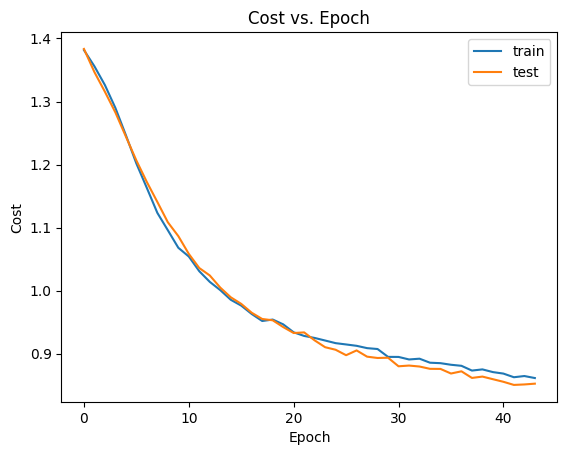

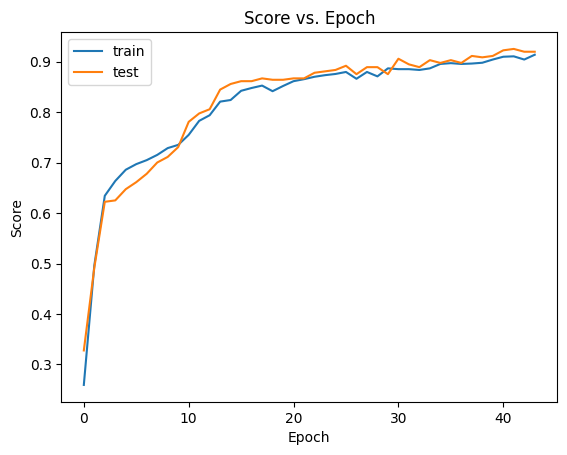

In [51]:
fit(train_set, trainloader, val_set, valloader, model, criterion, optimizer, device,scheduler, callback, epoch)

In [52]:
!pip install torchsummary

In [58]:
test_transform = transforms.Compose([
    transforms.Resize(size=(img_size)),
    transforms.ToTensor()
])
test_set = datasets.ImageFolder('/kaggle/input/padi-data/test', transform=test_transform)
testloader = DataLoader(test_set, shuffle=False)

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [60]:
def evaluate_model(model, testloader, criterion, device):
    model.load_state_dict(torch.load('/kaggle/working/model/best_model.pth'))
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    average_loss = total_loss / len(testloader)
    accuracy = sum(np.array(all_labels) == np.array(all_predictions)) / len(all_labels)
    
    class_counts_labels = np.bincount(all_labels)
    class_counts_predictions = np.bincount(all_predictions)

    print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    print("Classification Report:")
    print(classification_report(all_labels, all_predictions))

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_set.classes, yticklabels=test_set.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Test Loss: 0.8906, Test Accuracy: 0.8833
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.76        45
           1       0.91      0.87      0.89        45
           2       0.89      0.91      0.90        45
           3       0.96      1.00      0.98        45

    accuracy                           0.88       180
   macro avg       0.88      0.88      0.88       180
weighted avg       0.88      0.88      0.88       180

Confusion Matrix:


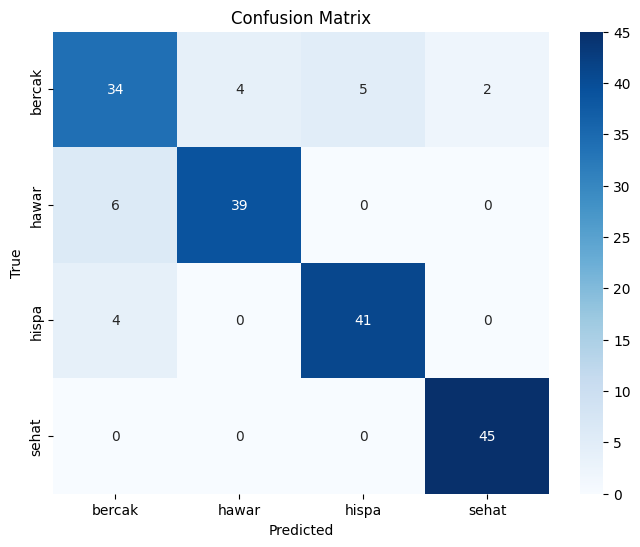

In [61]:
evaluate_model(model, testloader, criterion, device)

In [62]:
from torchsummary import summary

model = CNNpenyakitPadi(output_size = 6).to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,640
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,496
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,856
      BatchNorm2d-14          [-1, 128,

In [67]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image


activation1 = {}
jumlah = 100

def get_activation(name):
    def hook(module, input, output):
        activation1[name] = output.detach()
    return hook

model.feature[0][0].register_forward_hook(get_activation('conv'))
model.feature[2][0].register_forward_hook(get_activation('conv2'))
model.feature[4][0].register_forward_hook(get_activation('conv4'))

model.feature[0][2].register_forward_hook(get_activation('relu'))
model.feature[2][2].register_forward_hook(get_activation('relu3'))
model.feature[4][2].register_forward_hook(get_activation('relu5'))


img = Image.open('/kaggle/input/data-padi/test/bercak/IMG000000000013.jpg')
rgb_image = img.convert('RGB')

transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])
img_tensor = transform(rgb_image)
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor

output = model(img_tensor)

/tmp/ipykernel_47/2727268787.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1)


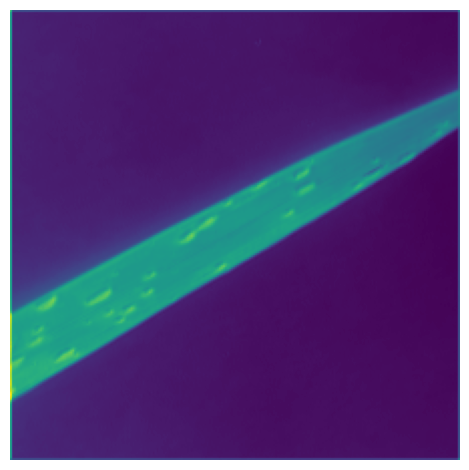

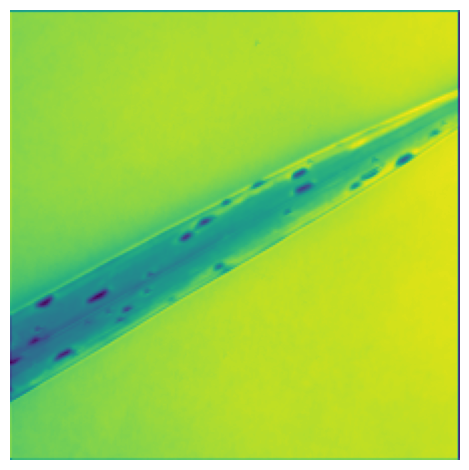

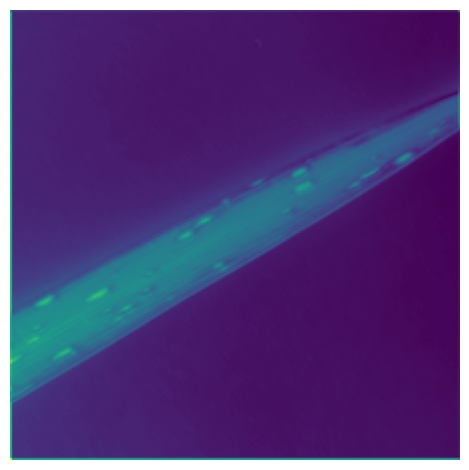

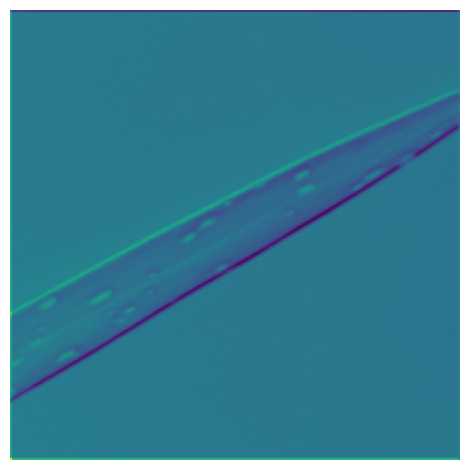

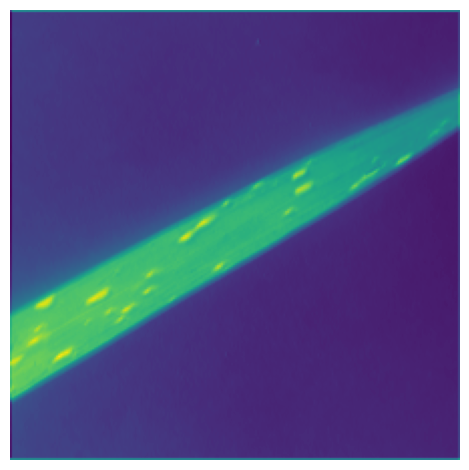

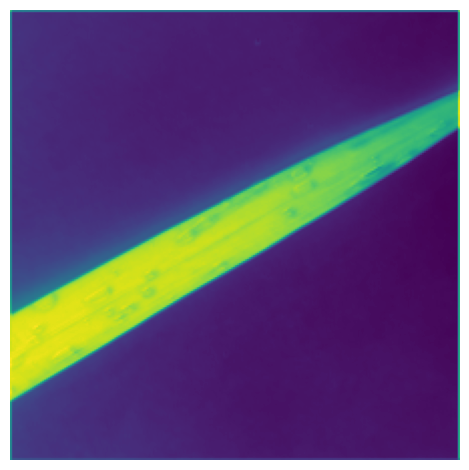

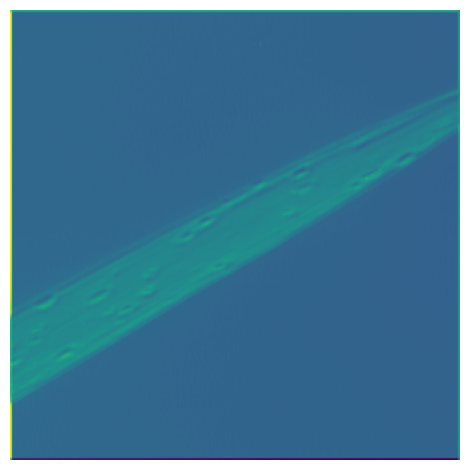

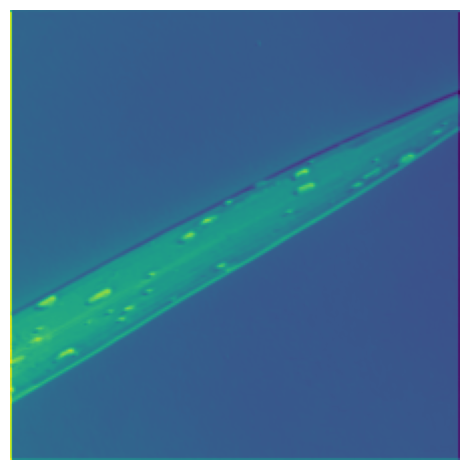

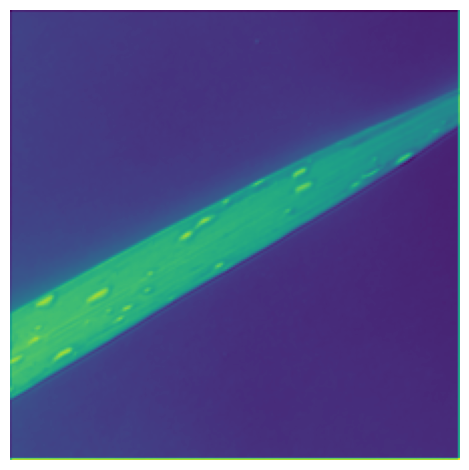

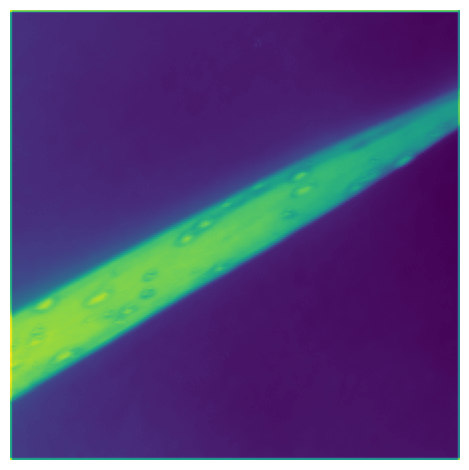

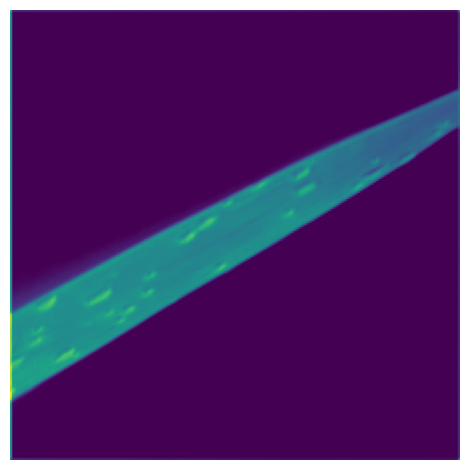

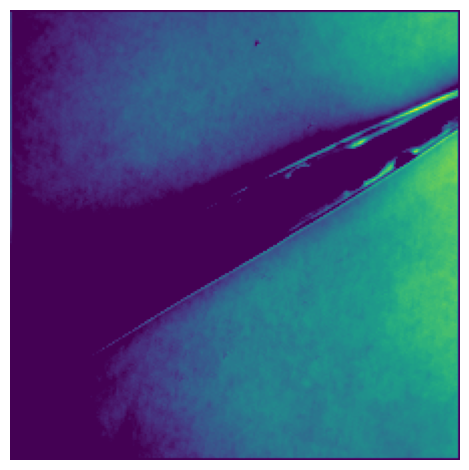

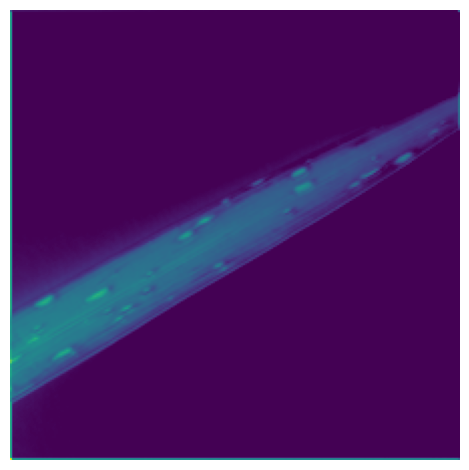

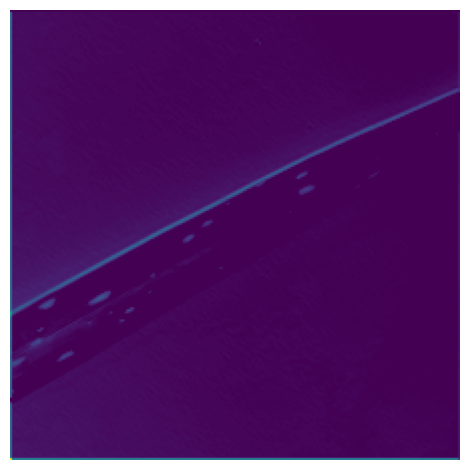

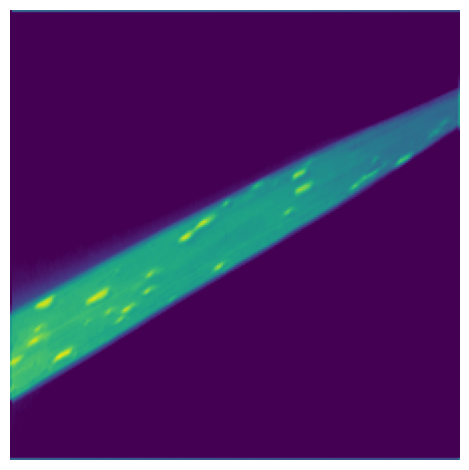

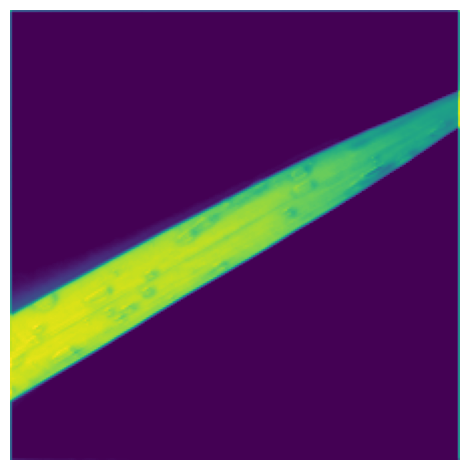

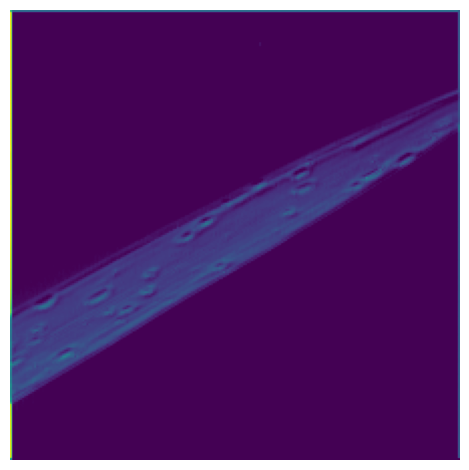

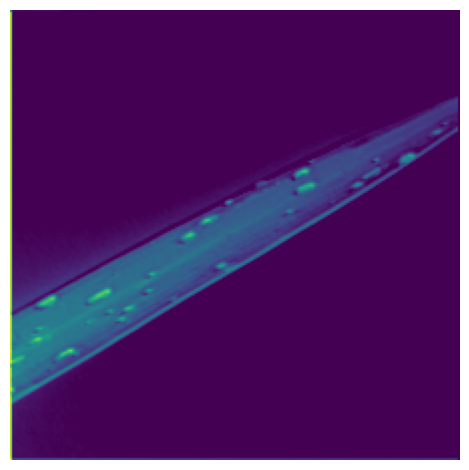

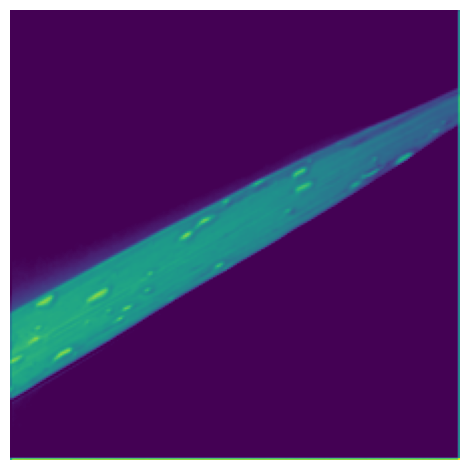

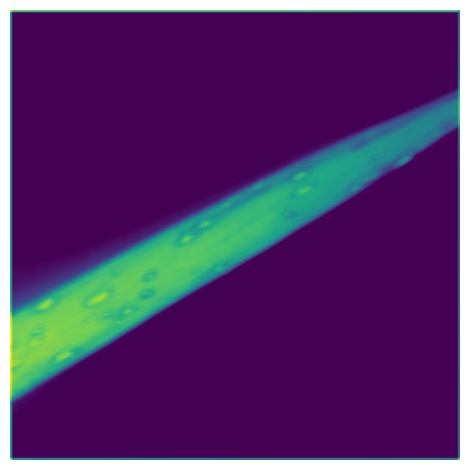

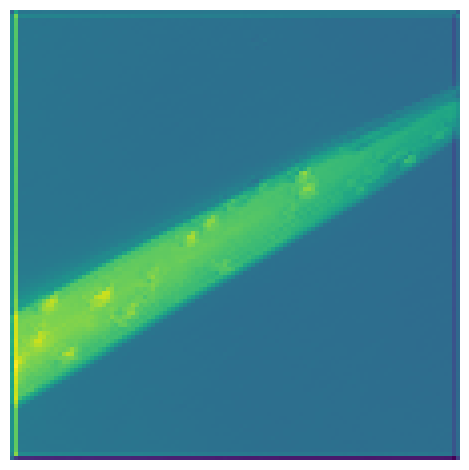

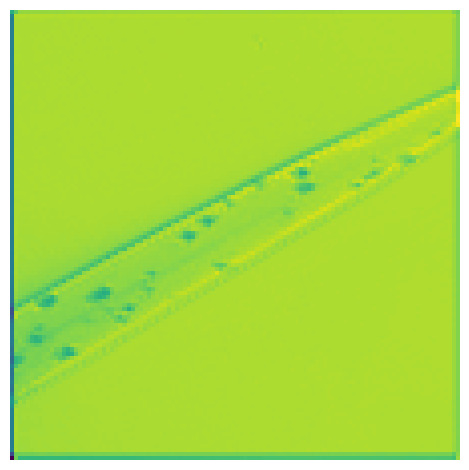

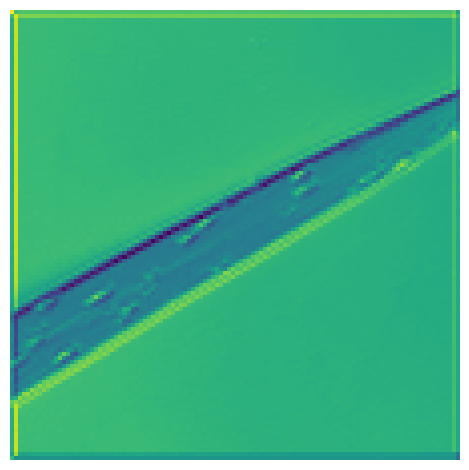

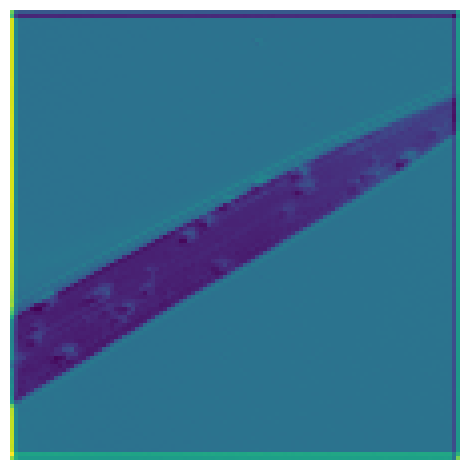

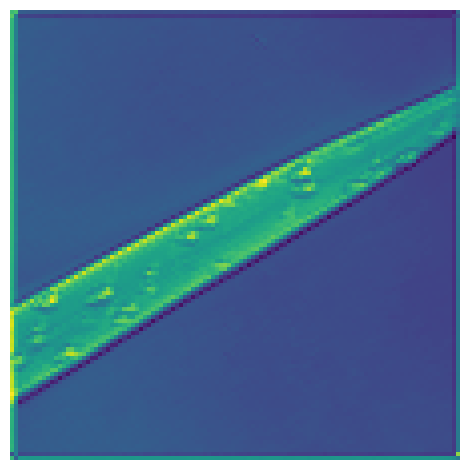

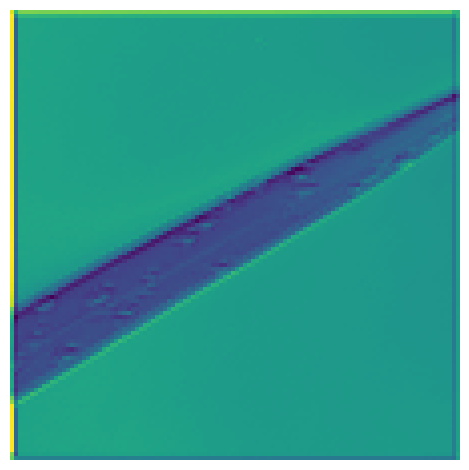

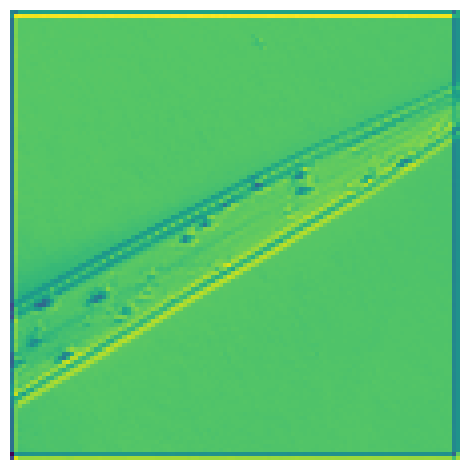

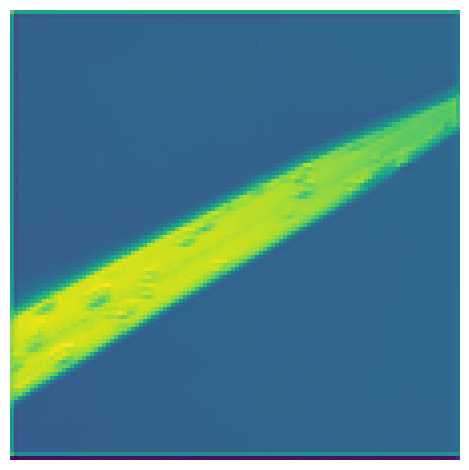

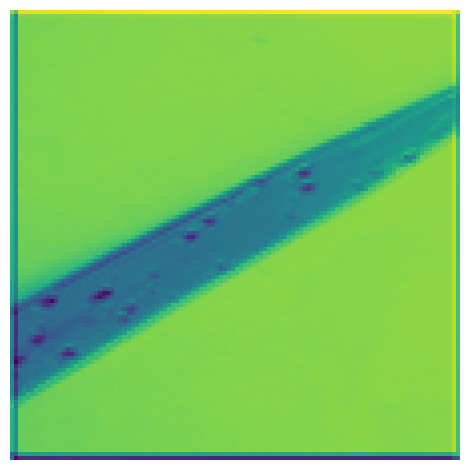

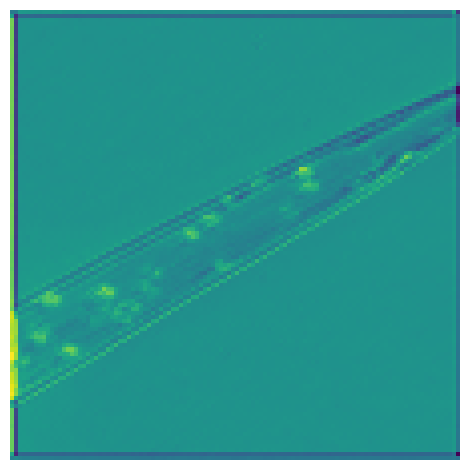

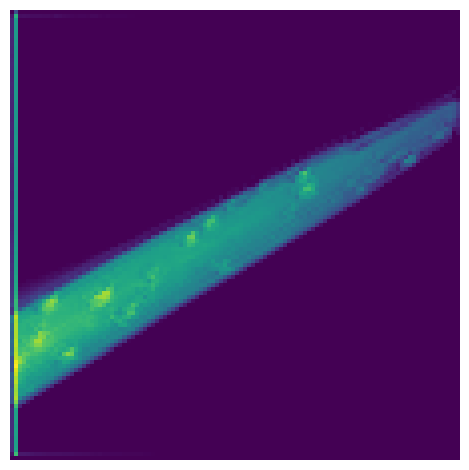

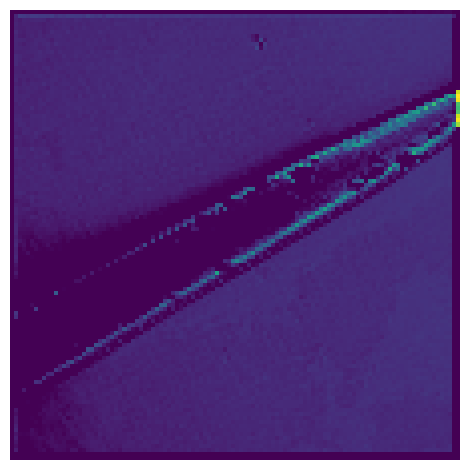

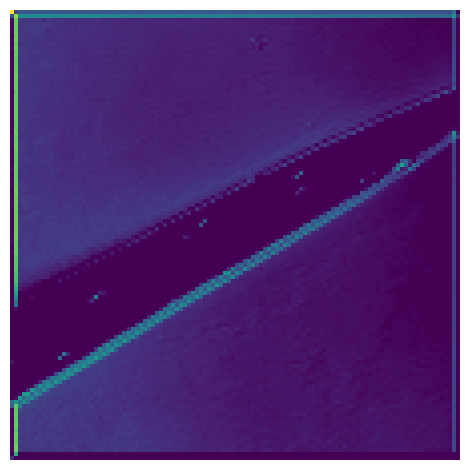

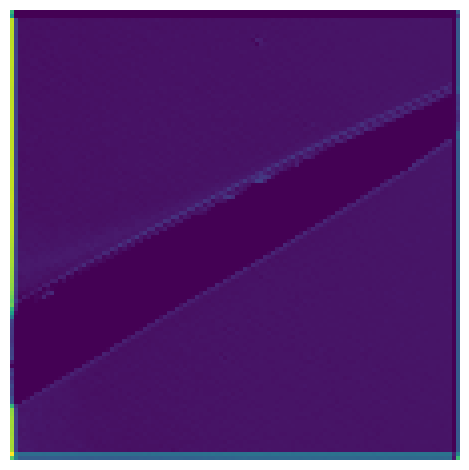

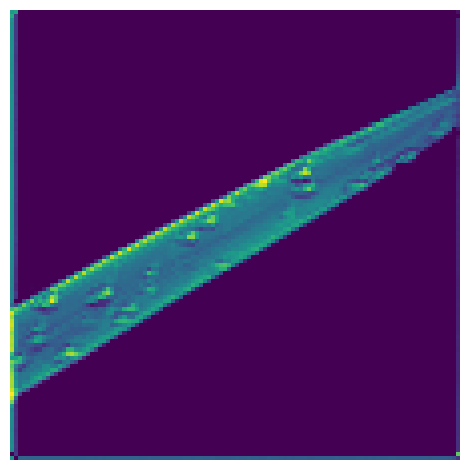

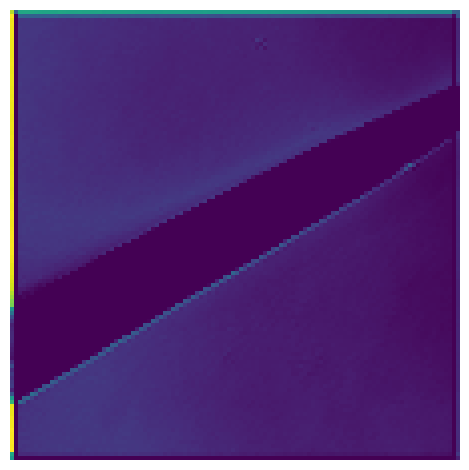

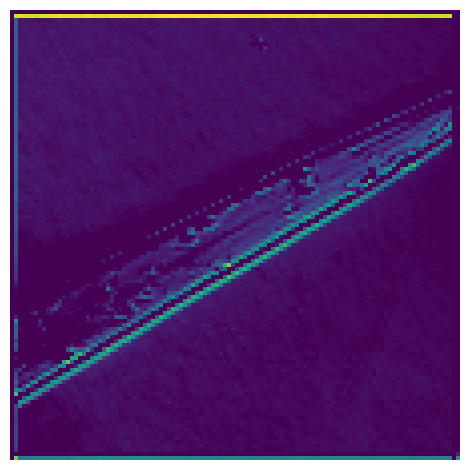

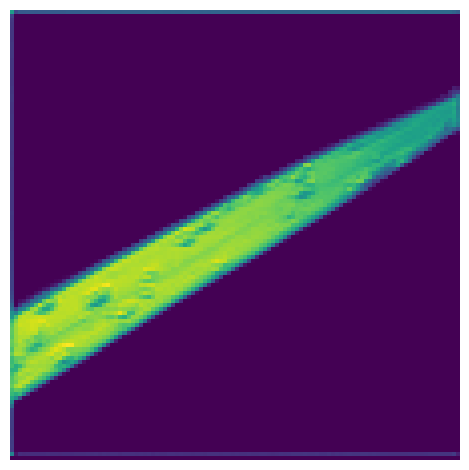

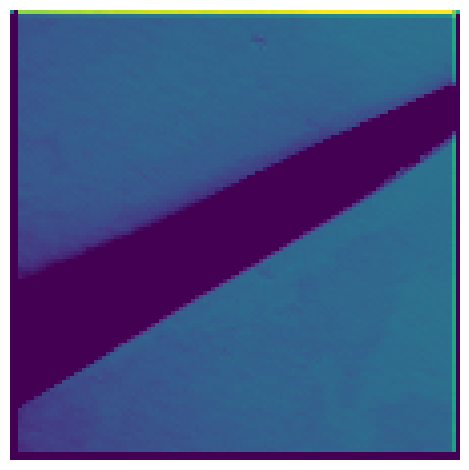

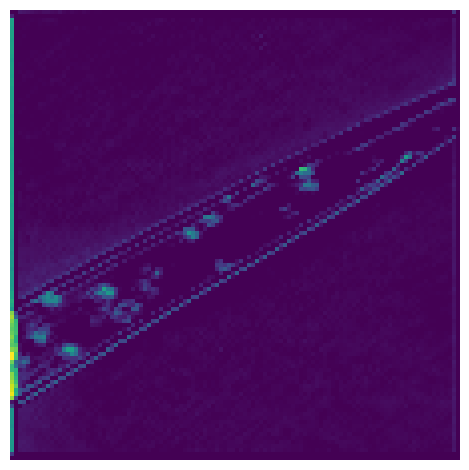

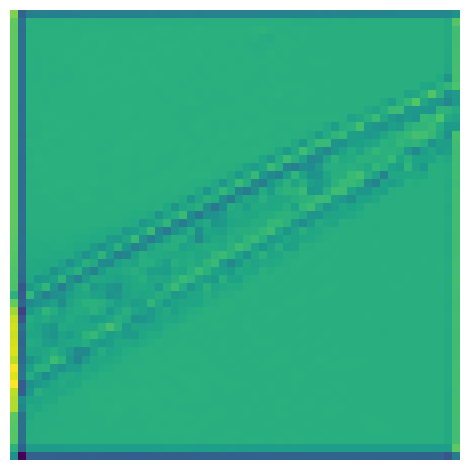

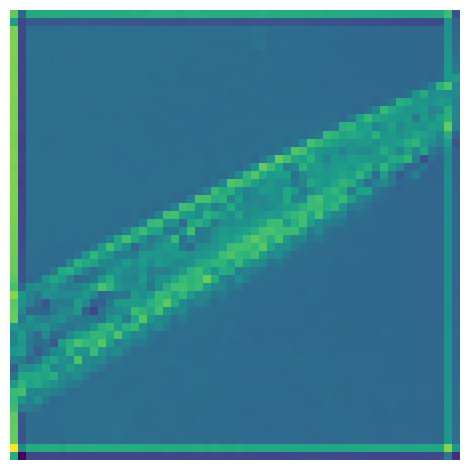

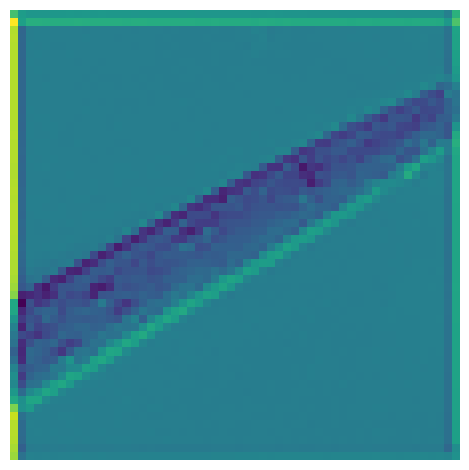

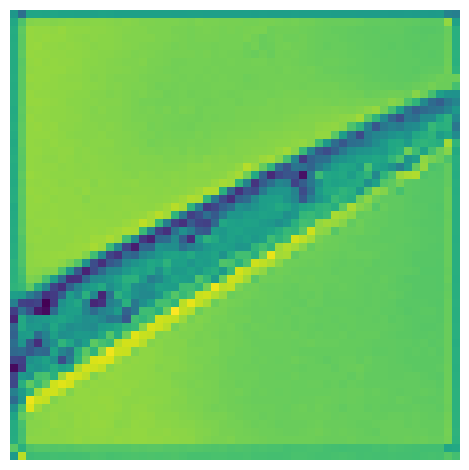

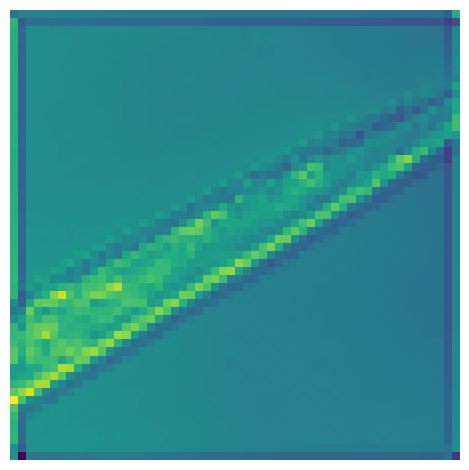

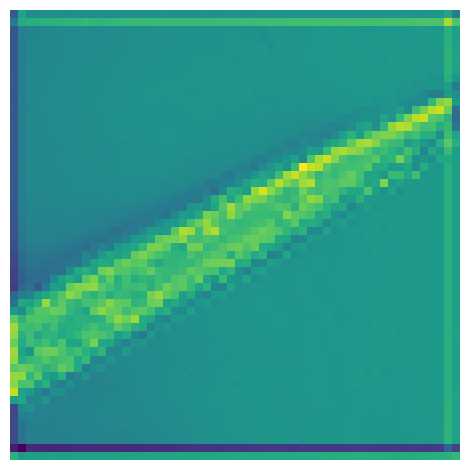

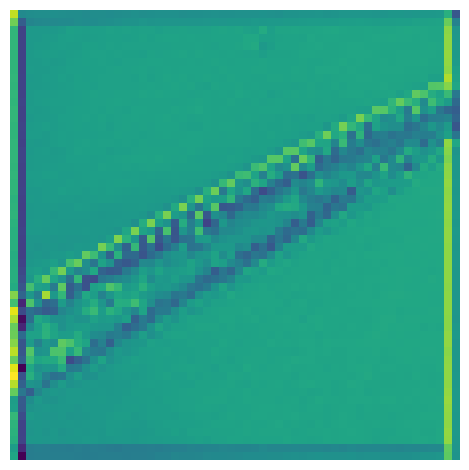

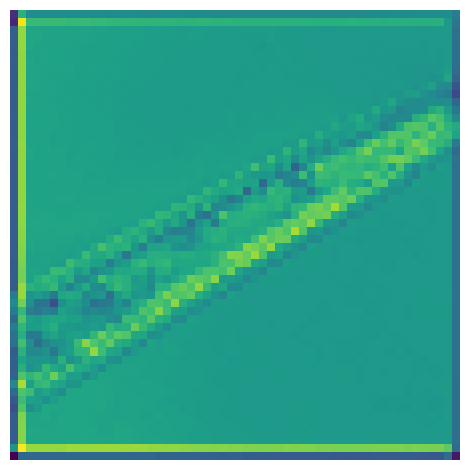

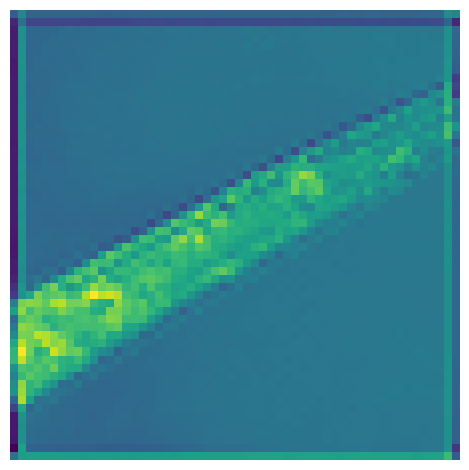

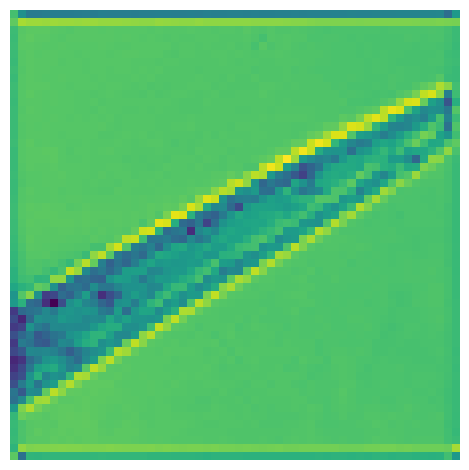

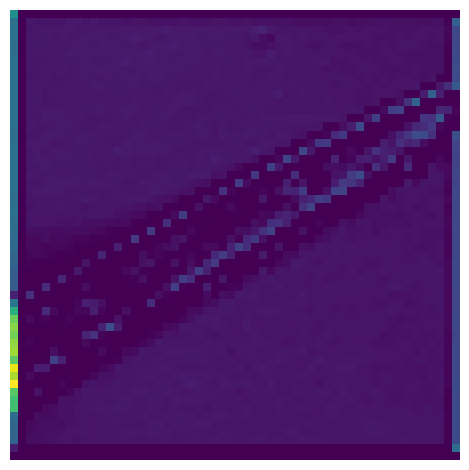

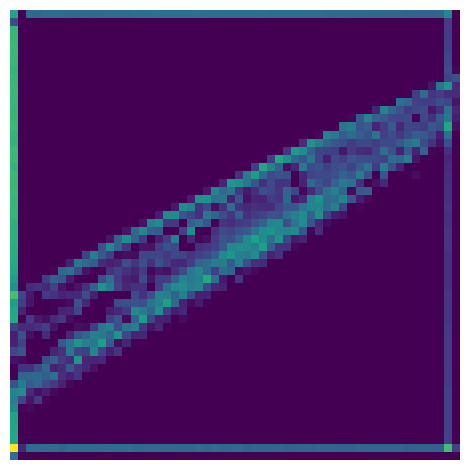

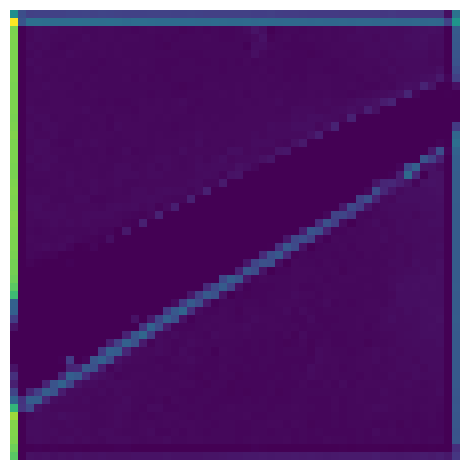

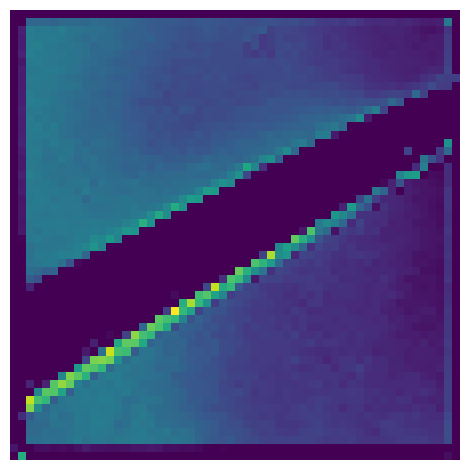

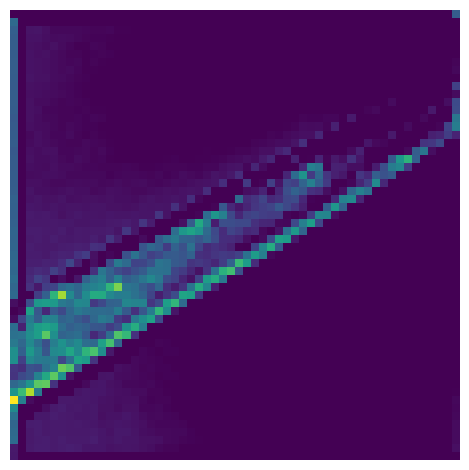

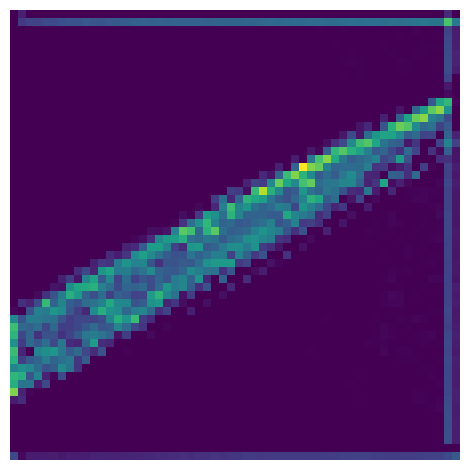

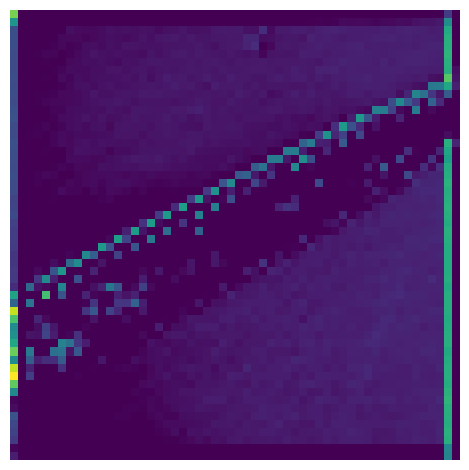

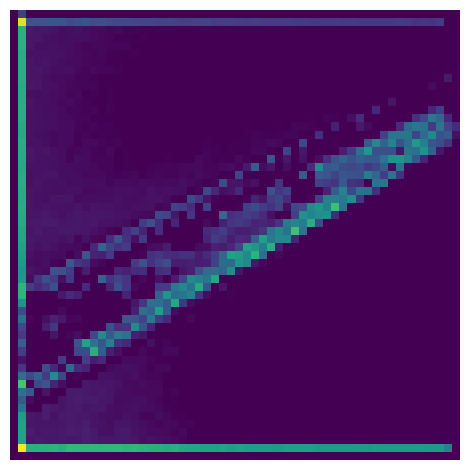

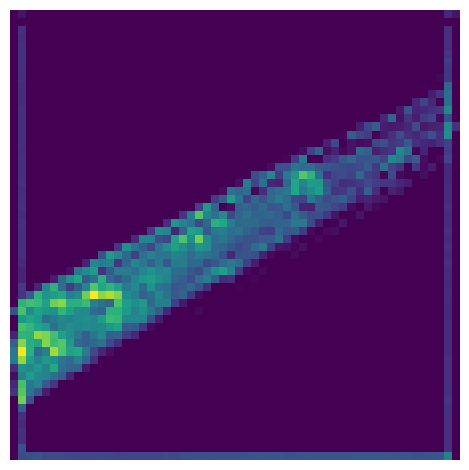

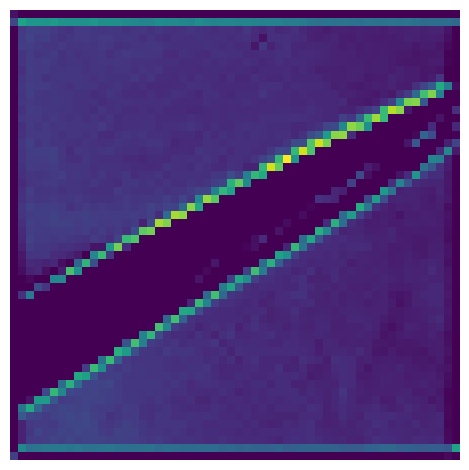

In [68]:
for name in activation1:
    folder_path = os.path.join('custom_12', name)
    file = name

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    if file in activation1:
        num_images = min(max(3, activation1[file].shape[1]), 10)
        for i in range(num_images):
            fig, ax = plt.subplots(1, 1)
            ax.imshow(activation1[file][0, i].cpu().numpy())
            ax.axis('off')
            plt.tight_layout()

            fig.savefig(f'{folder_path}/{file}-{i}.png', dpi=300, transparent=True)


tensor([[[[1.0000, 0.9725, 0.7686, 0.9137, 1.0000, 1.0000],
          [1.0000, 0.9686, 0.7373, 0.8941, 1.0000, 1.0000],
          [1.0000, 0.9647, 0.7373, 0.8784, 1.0000, 1.0000],
          [1.0000, 0.9529, 0.7059, 0.8745, 1.0000, 1.0000],
          [1.0000, 0.9451, 0.6941, 0.8392, 0.9922, 1.0000],
          [1.0000, 0.9490, 0.6824, 0.7882, 0.9882, 1.0000]],

         [[1.0000, 0.9647, 0.7098, 0.8902, 1.0000, 1.0000],
          [1.0000, 0.9686, 0.7725, 0.8980, 1.0000, 1.0000],
          [1.0000, 0.9608, 0.7529, 0.8706, 0.9961, 1.0000],
          [1.0000, 0.9451, 0.6902, 0.8627, 0.9961, 1.0000],
          [1.0000, 0.9451, 0.7059, 0.8078, 0.9922, 1.0000],
          [1.0000, 0.9451, 0.6588, 0.7843, 0.9843, 1.0000]],

         [[1.0000, 0.9333, 0.4471, 0.7333, 1.0000, 1.0000],
          [1.0000, 0.9294, 0.4235, 0.6902, 1.0000, 1.0000],
          [1.0000, 0.9255, 0.4118, 0.6431, 0.9922, 1.0000],
          [1.0000, 0.9216, 0.3882, 0.6039, 0.9882, 1.0000],
          [1.0000, 0.9176, 0.3608, 0

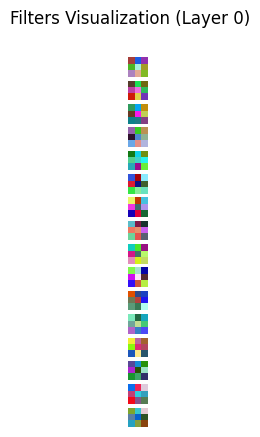

bias :tensor([ 0.1714,  0.0311, -0.1040,  0.1539,  0.0646, -0.1890, -0.1161,  0.1398,
         0.0832,  0.1654,  0.1799, -0.1457,  0.1267,  0.0715,  0.0372, -0.0259])


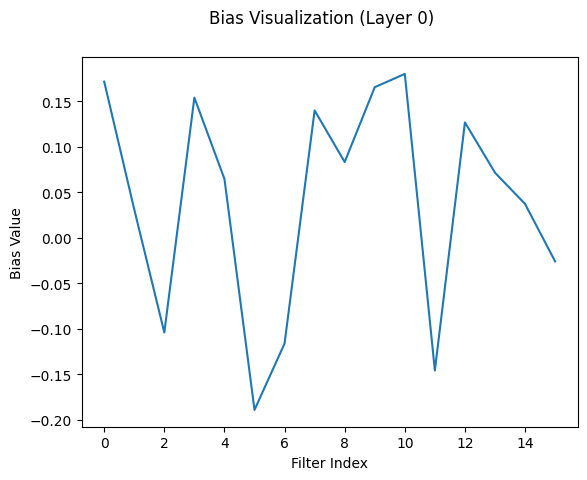

fitur :tensor([[[[ 7.3108e-01,  8.3670e-01,  6.0059e-01,  6.5794e-01,  7.5449e-01,
            8.3441e-01],
          [ 6.6542e-01,  6.1410e-01,  3.7044e-01,  4.9814e-01,  5.8073e-01,
            6.4239e-01],
          [ 6.6363e-01,  5.9719e-01,  3.5656e-01,  4.7061e-01,  5.8259e-01,
            6.4275e-01],
          [ 6.6381e-01,  5.9727e-01,  3.4744e-01,  4.5062e-01,  5.8097e-01,
            6.4278e-01],
          [ 6.6515e-01,  6.0578e-01,  3.5981e-01,  4.2440e-01,  5.7666e-01,
            6.4247e-01],
          [ 4.5571e-01,  1.8492e-01,  2.5951e-02,  1.7680e-01,  2.9703e-01,
            2.3435e-01]],

         [[ 3.7935e-01,  2.1595e-01,  9.8757e-02,  2.4656e-01,  2.6491e-01,
            3.5302e-01],
          [ 1.0034e-01, -2.4729e-01, -3.9968e-01, -2.2638e-01, -2.6239e-01,
           -2.4506e-03],
          [ 1.0260e-01, -2.4340e-01, -3.8715e-01, -2.1742e-01, -2.5096e-01,
           -1.8059e-03],
          [ 1.0371e-01, -2.4845e-01, -3.8099e-01, -2.2061e-01, -2.2698e-01,
      

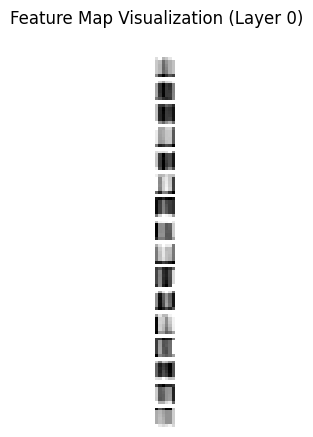

relu :tensor([[[[7.3108e-01, 8.3670e-01, 6.0059e-01, 6.5794e-01, 7.5449e-01,
           8.3441e-01],
          [6.6542e-01, 6.1410e-01, 3.7044e-01, 4.9814e-01, 5.8073e-01,
           6.4239e-01],
          [6.6363e-01, 5.9719e-01, 3.5656e-01, 4.7061e-01, 5.8259e-01,
           6.4275e-01],
          [6.6381e-01, 5.9727e-01, 3.4744e-01, 4.5062e-01, 5.8097e-01,
           6.4278e-01],
          [6.6515e-01, 6.0578e-01, 3.5981e-01, 4.2440e-01, 5.7666e-01,
           6.4247e-01],
          [4.5571e-01, 1.8492e-01, 2.5951e-02, 1.7680e-01, 2.9703e-01,
           2.3435e-01]],

         [[3.7935e-01, 2.1595e-01, 9.8757e-02, 2.4656e-01, 2.6491e-01,
           3.5302e-01],
          [1.0034e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [1.0260e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [1.0371e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           1.1102e-03],
          [1.0630e-01, 0.0000e+00, 0.0000e

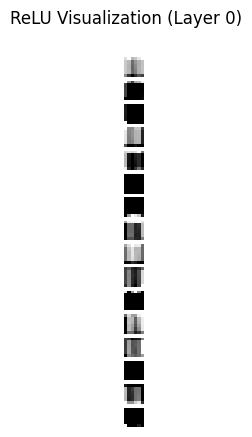

In [69]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def visualize_filters(model, layer_idx):
    layer = model.feature[layer_idx][0]
    filters = layer.weight.data
    filters = filters - filters.min()
    filters = filters / filters.max()

    fig, axs = plt.subplots(filters.size(0))
    fig.suptitle('Filters Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        filter_img = filters[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(filter_img.squeeze(), cmap='gray')  
        ax.axis('off')
        print(f"filer :{filter_img}")

    plt.show()
    
def visualize_bias(model, layer_idx):
    layer = model.feature[layer_idx][0]
    bias = layer.bias.data

    fig, ax = plt.subplots()
    fig.suptitle('Bias Visualization (Layer {})'.format(layer_idx))

    ax.plot(bias.cpu().numpy())
    ax.set_xlabel('Filter Index')
    ax.set_ylabel('Bias Value')
    print(f"bias :{bias}")
    plt.show()
    
    

def visualize_feature_maps(model, layer_idx, input_image):
    activations = model.feature[0][layer_idx](input_image)
    activations = activations.detach()

    fig, axs = plt.subplots(activations.size(1))
    fig.suptitle('Feature Map Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"fitur :{activations}")

    plt.show()

def visualize_relu(model, layer_idx, input_image):
    activations = model.feature[0][layer_idx](input_image)
    relu_activations = torch.relu(activations)
    relu_activations = relu_activations.detach()

    fig, axs = plt.subplots(relu_activations.size(1))
    fig.suptitle('ReLU Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(relu_activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"relu :{relu_activations}")

    plt.show()

output_size = 10  
model = CNNpenyakitPadi(output_size)

transform = transforms.Compose([
    transforms.Resize((6,6)),
    transforms.ToTensor()
])

image_path = '/kaggle/input/rice-desease/datapadi/test/brown_spot/brown_val (50).jpg' 
input_image = Image.open(image_path)
input_image = transform(input_image).unsqueeze(0)


print(input_image)


visualize_filters(model, 0)

visualize_bias(model, 0)

visualize_feature_maps(model, 0, input_image)

visualize_relu(model, 0, input_image)